<a href="https://colab.research.google.com/github/Jane0731/Homework/blob/main/VAE_Diffusion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Áπ™Âúñ‰∏≠ÊñáË®≠ÂÆö

In [ ]:
# Colab ÈÄ≤Ë°åmatplotlibÁπ™ÂúñÊôÇÈ°ØÁ§∫ÁπÅÈ´î‰∏≠Êñá
# ‰∏ãËºâÂè∞ÂåóÊÄùÊ∫êÈªëÈ´î‰∏¶ÂëΩÂêçtaipei_sans_tc_beta.ttfÔºåÁßªËá≥ÊåáÂÆöË∑ØÂæë
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# ÊîπstyleË¶ÅÂú®Êîπfont‰πãÂâç
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

print(" Áí∞Â¢ÉË®≠ÁΩÆÂÆåÊàêÔºÅ")

--2025-09-26 04:40:37--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 64.233.170.102, 64.233.170.139, 64.233.170.101, ...
Connecting to drive.google.com (drive.google.com)|64.233.170.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-09-26 04:40:38--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 64.233.170.132, 2404:6800:4003:c1a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|64.233.170.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‚ÄòTaipeiSansTCBeta-Regular.ttf‚Äô

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  42.1MB/s    in 0.5s    

2025-09-26 04

#ÂõõÁ®ÆÊ®°Âûã

##VAE

### Ê®°ÂûãË®≠ÂÆö


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time

class VAE(nn.Module):
    """
    Variational Autoencoder for MNIST
    ÊåâÁÖßË¶ÅÊ±ÇÔºöÂ∞ÜËæìÂÖ•ÂõæÂÉèÂ±ïÂπ≥ÔºåÂéãÁº©Âà∞ÊΩúÂú®Á©∫Èó¥(z)ÔºåËæìÂá∫ÂùáÂÄºŒº‰∏éÂØπÊï∞ÊñπÂ∑Ælog œÉ¬≤
    """
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        self.input_dim = input_dim  # 28*28 = 784
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim  # ÊΩúÂú®Á©∫Èó¥Áª¥Â∫¶

        # Encoder: Â∞ÜËæìÂÖ•ÂõæÂÉèÁºñÁ†ÅÂà∞ÊΩúÂú®Á©∫Èó¥
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        # ÊΩúÂú®Á©∫Èó¥ÁöÑÂùáÂÄºÂíåÂØπÊï∞ÊñπÂ∑Æ
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)      # ÂùáÂÄº Œº
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)  # ÂØπÊï∞ÊñπÂ∑Æ log œÉ¬≤

        # Decoder: ‰ªéÊΩúÂú®Á©∫Èó¥zËøòÂéüÂõæÂÉè (28√ó28)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # ËæìÂá∫Âà∞[0,1]ËåÉÂõ¥
        )

    def encode(self, x):
        """ÁºñÁ†ÅÔºöËæìÂÖ•ÂõæÂÉè -> ÊΩúÂú®Á©∫Èó¥ÂèÇÊï∞ (Œº, log œÉ¬≤)"""
        # Â±ïÂπ≥ÂõæÂÉè
        x = x.view(x.size(0), -1)  # (batch_size, 784)

        # ÈÄöËøáÁºñÁ†ÅÂô®
        h = self.encoder(x)

        # ËæìÂá∫ÂùáÂÄºÂíåÂØπÊï∞ÊñπÂ∑Æ
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        """ÈáçÂèÇÊï∞ÂåñÊäÄÂ∑ßÔºö‰ªé N(Œº, œÉ¬≤) ÈááÊ†∑"""
        std = torch.exp(0.5 * logvar)  # œÉ = exp(0.5 * log œÉ¬≤)
        eps = torch.randn_like(std)    # ‰ªéÊ†áÂáÜÊ≠£ÊÄÅÂàÜÂ∏ÉÈááÊ†∑
        z = mu + eps * std             # z = Œº + Œµ * œÉ
        return z

    def decode(self, z):
        """Ëß£Á†ÅÔºöÊΩúÂú®ÂèòÈáèz -> ÈáçÊûÑÂõæÂÉè"""
        x_recon = self.decoder(z)
        return x_recon.view(x_recon.size(0), 1, 28, 28)  # ÈáçÂ°ë‰∏∫ÂõæÂÉèÊ†ºÂºè

    def forward(self, x):
        """VAEÂâçÂêë‰º†Êí≠"""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

    def sample(self, num_samples=10, device='cpu'):
        """‰ªéÊΩúÂú®Á©∫Èó¥ÈááÊ†∑ÁîüÊàêÊñ∞ÂõæÂÉè"""
        with torch.no_grad():
            # ‰ªéÊ†áÂáÜÊ≠£ÊÄÅÂàÜÂ∏ÉÈááÊ†∑
            z = torch.randn(num_samples, self.latent_dim).to(device)
            samples = self.decode(z)
        return samples


def vae_loss_function(recon_x, x, mu, logvar):
    """
    VAEÊçüÂ§±ÂáΩÊï∞ = ÈáçÂª∫ÊçüÂ§±(BCE) + KLÊï£Â∫¶ÊçüÂ§±
    """
    # ÈáçÂª∫ÊçüÂ§± (Binary Cross Entropy)
    BCE = F.binary_cross_entropy(
        recon_x.view(-1, 784),
        x.view(-1, 784),
        reduction='sum'
    )

    # KLÊï£Â∫¶ÊçüÂ§±: D_KL(q(z|x) || p(z))
    # ÂÖ∂‰∏≠ q(z|x) = N(Œº, œÉ¬≤), p(z) = N(0, I)
    # KLD = -0.5 * sum(1 + log œÉ¬≤ - Œº¬≤ - œÉ¬≤)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

### Ë≥áÊñôÈ†êËôïÁêÜÊî∂ÈõÜ

In [ ]:

def get_mnist_dataloaders(batch_size=128):
    """
    ËΩΩÂÖ•MNISTÊï∞ÊçÆÈõÜ - ÁÆÄÂåñÁâàÔºöËÆ≠ÁªÉÈõÜ + ÊµãËØïÈõÜ
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # ËÆ≠ÁªÉÈõÜ
    train_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        transform=transform,
        download=True
    )

    # ÊµãËØïÈõÜ
    test_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=False,
        transform=transform,
        download=True
    )

    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    test_dataloader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    print(f"Êï∞ÊçÆÈõÜ‰ø°ÊÅØ:")
    print(f"  ËÆ≠ÁªÉÈõÜ: {len(train_dataset)} Âº†ÂõæÁâá")
    print(f"  ÊµãËØïÈõÜ: {len(test_dataset)} Âº†ÂõæÁâá")

    return train_dataloader, test_dataloader


### Ë®ìÁ∑¥ÂíåÂèØË¶ñÂåñ

In [ ]:
def train_vae_model(model, train_dataloader, test_dataloader, epochs=30, lr=1e-3, device='cuda'):
    """
    Ë®ìÁ∑¥VAEÊ®°Âûã - ÂåÖÂê´Ë®ìÁ∑¥ÈõÜÂíåÊ∏¨Ë©¶ÈõÜË©ï‰º∞
    ÊåâÁÖßË¶ÅÊ±ÇÔºö
    - Batch size: 128
    - Optimizer: Adam, lr=1e-3
    - Loss: ÈáçÂª∫BCE + KLD
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.to(device)

    # Ë®ìÁ∑¥Áõ£ÊéßÊåáÊ®ô
    training_metrics = {
        'train_losses': [],      # Ë®ìÁ∑¥ÊêçÂ§±
        'test_losses': [],       # Ê∏¨Ë©¶ÊêçÂ§±
        'train_bce_losses': [],  # Ë®ìÁ∑¥ÈáçÂª∫ÊêçÂ§±
        'train_kld_losses': [],  # Ë®ìÁ∑¥KLÊï£Â∫¶ÊêçÂ§±
        'batch_losses': [],
        'gradient_norms': [],
        'epoch_times': [],
        'total_training_time': 0
    }

    print("ÈñãÂßãË®ìÁ∑¥MNIST VAEÊ®°Âûã...")
    print(f"Ë®ìÁ∑¥ÈõÜÂ§ßÂ∞è: {len(train_dataloader.dataset)}")
    print(f"Ê∏¨Ë©¶ÈõÜÂ§ßÂ∞è: {len(test_dataloader.dataset)}")
    print(f"ÊâπÊ¨°Â§ßÂ∞è: {train_dataloader.batch_size}")
    print(f"Ë®ìÁ∑¥ÊâπÊ¨°Êï∏: {len(train_dataloader)}")
    print("=" * 60)

    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()

        # ============ Ë®ìÁ∑¥ÈöéÊÆµ ============
        model.train()
        total_train_loss = 0
        total_train_bce = 0
        total_train_kld = 0
        num_batches = len(train_dataloader)
        epoch_gradient_norms = []

        for batch_idx, (data, _) in enumerate(train_dataloader):
            data = data.to(device)

            # ÂâçÂêëÂÇ≥Êí≠
            recon_batch, mu, logvar = model(data)

            # Ë®àÁÆóÊêçÂ§±
            loss, bce, kld = vae_loss_function(recon_batch, data, mu, logvar)

            # ÂèçÂêëÂÇ≥Êí≠
            optimizer.zero_grad()
            loss.backward()

            # Ë®àÁÆóÊ¢ØÂ∫¶ÁØÑÊï∏
            total_grad_norm = 0
            for param in model.parameters():
                if param.grad is not None:
                    param_grad_norm = param.grad.data.norm(2)
                    total_grad_norm += param_grad_norm.item() ** 2
            total_grad_norm = total_grad_norm ** (1. / 2)
            epoch_gradient_norms.append(total_grad_norm)

            optimizer.step()

            # Ë®òÈåÑÊêçÂ§±
            total_train_loss += loss.item()
            total_train_bce += bce.item()
            total_train_kld += kld.item()
            training_metrics['batch_losses'].append(loss.item())

            # ÊØè200ÂÄãÊâπÊ¨°‰∏îÊØè10ÂÄãepochÈ°ØÁ§∫ÈÄ≤Â∫¶
            if epoch % 10 == 0:
                if batch_idx % 200 == 0:
                    print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{num_batches}], '
                          f'Total Loss: {loss.item()/len(data):.4f}, BCE: {bce.item()/len(data):.4f}, '
                          f'KLD: {kld.item()/len(data):.4f}')

        # ============ Ê∏¨Ë©¶ÈöéÊÆµ ============
        model.eval()
        total_test_loss = 0
        test_batches = len(test_dataloader)

        with torch.no_grad():
            for data, _ in test_dataloader:
                data = data.to(device)
                recon_batch, mu, logvar = model(data)
                loss, _, _ = vae_loss_function(recon_batch, data, mu, logvar)
                total_test_loss += loss.item()

        # Ë®òÈåÑepochÊåáÊ®ô
        epoch_time = time.time() - epoch_start_time
        avg_train_loss = total_train_loss / len(train_dataloader.dataset)
        avg_test_loss = total_test_loss / len(test_dataloader.dataset)
        avg_train_bce = total_train_bce / len(train_dataloader.dataset)
        avg_train_kld = total_train_kld / len(train_dataloader.dataset)
        avg_grad_norm = sum(epoch_gradient_norms) / len(epoch_gradient_norms)

        training_metrics['train_losses'].append(avg_train_loss)
        training_metrics['test_losses'].append(avg_test_loss)
        training_metrics['train_bce_losses'].append(avg_train_bce)
        training_metrics['train_kld_losses'].append(avg_train_kld)
        training_metrics['gradient_norms'].append(avg_grad_norm)
        training_metrics['epoch_times'].append(epoch_time)

        print(f'Epoch [{epoch+1}/{epochs}] - Ë®ìÁ∑¥ÊêçÂ§±: {avg_train_loss:.4f}, '
              f'Ê∏¨Ë©¶ÊêçÂ§±: {avg_test_loss:.4f}, ÈáçÂª∫ÊêçÂ§±: {avg_train_bce:.4f}, '
              f'KLÊêçÂ§±: {avg_train_kld:.4f}, Ê¢ØÂ∫¶ÁØÑÊï∏: {avg_grad_norm:.4f}, '
              f'Áî®ÊôÇ: {epoch_time:.1f}Áßí')
        print("-" * 60)

    # Á∏ΩË®ìÁ∑¥ÊôÇÈñì
    total_training_time = time.time() - total_start_time
    training_metrics['total_training_time'] = total_training_time

    print("=" * 60)
    print("VAEË®ìÁ∑¥ÂÆåÊàêÔºÅ")
    print(f"Á∏ΩË®ìÁ∑¥ÊôÇÈñì: {total_training_time/60:.2f} ÂàÜÈêò")
    print(f"Âπ≥ÂùáÊØèepochÊôÇÈñì: {np.mean(training_metrics['epoch_times']):.1f} Áßí")
    print(f"ÊúÄÁµÇË®ìÁ∑¥ÊêçÂ§±: {training_metrics['train_losses'][-1]:.4f}")
    print(f"ÊúÄÁµÇÊ∏¨Ë©¶ÊêçÂ§±: {training_metrics['test_losses'][-1]:.4f}")
    print("=" * 60)

    return model, training_metrics


def generate_vae_images(model, num_images=10, device='cuda'):
    """
    Èö®Ê©üÁîüÊàêVAEÂúñÂÉè - Â¢ûÂä†Êé®ÁêÜÊôÇÈñìË®òÈåÑ
    """
    model.eval()

    # Ë®≠ÂÆöÈö®Ê©üÁ®ÆÂ≠ê (seed=42)
    torch.manual_seed(42)

    # Êé®ÁêÜË®àÊôÇÈñãÂßã
    inference_start_time = time.time()

    print(f"Ê≠£Âú®ÁîüÊàê {num_images} ÂºµMNISTÂúñÂÉè...")
    generated_images = model.sample(num_images, device=device)

    # Êé®ÁêÜË®àÊôÇÁµêÊùü
    inference_time = time.time() - inference_start_time

    print(f"VAEÁîüÊàêÂÆåÊàêÔºÅÊé®ÁêÜÊôÇÈñì: {inference_time:.4f} Áßí")
    print(f"Âπ≥ÂùáÊØèÂºµÂúñÁâá: {inference_time/num_images:.4f} Áßí")

    return generated_images, inference_time


def visualize_vae_images(images, title="Generated VAE MNIST Images", inference_time=None):
    """
    Ë¶ñË¶∫ÂåñVAEÁîüÊàêÁöÑMNISTÂúñÁâá - Â¢ûÂä†Êé®ÁêÜÊôÇÈñìÈ°ØÁ§∫
    """
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))

    # Ê®ôÈ°å‰∏≠Âä†ÂÖ•Êé®ÁêÜÊôÇÈñìË≥áË®ä
    if inference_time is not None:
        full_title = f"{title}\nÊé®ÁêÜÊôÇÈñì: {inference_time:.4f}Áßí, Âπ≥ÂùáÊØèÂºµ: {inference_time/len(images):.4f}Áßí"
    else:
        full_title = title

    fig.suptitle(full_title, fontsize=14)

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            img = images[i].squeeze().cpu().numpy()
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            ax.set_title(f'Image {i+1}', fontsize=10)
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()


def plot_vae_training_metrics(training_metrics):
    """
    Áπ™Ë£ΩVAEË®ìÁ∑¥ÊåáÊ®ô - ÂåÖÂê´Ë®ìÁ∑¥ÊêçÂ§±ÂíåÊ∏¨Ë©¶ÊêçÂ§±Â∞çÊØî
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('VAE Ë®ìÁ∑¥ÊåáÊ®ôÂàÜÊûê', fontsize=16)

    epochs = range(1, len(training_metrics['train_losses'])+1)

    # 1. Ë®ìÁ∑¥ÊêçÂ§± vs Ê∏¨Ë©¶ÊêçÂ§±
    axes[0, 0].plot(epochs, training_metrics['train_losses'], 'b-',
                    linewidth=2, label='Ë®ìÁ∑¥ÈõÜÁ∏ΩÊêçÂ§±', marker='o', markersize=3)
    axes[0, 0].plot(epochs, training_metrics['test_losses'], 'r-',
                    linewidth=2, label='Ê∏¨Ë©¶ÈõÜÁ∏ΩÊêçÂ§±', marker='s', markersize=3)
    axes[0, 0].plot(epochs, training_metrics['train_bce_losses'], 'g--',
                    linewidth=1, label='Ë®ìÁ∑¥ÈáçÂª∫ÊêçÂ§±(BCE)', alpha=0.7)
    axes[0, 0].plot(epochs, training_metrics['train_kld_losses'], 'm--',
                    linewidth=1, label='Ë®ìÁ∑¥KLÊï£Â∫¶ÊêçÂ§±', alpha=0.7)
    axes[0, 0].set_title('VAEÊêçÂ§±ÁµÑ‰ª∂ÂàÜÊûê')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend(loc='upper right', fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Ê≥õÂåñÂàÜÊûê (Ë®ìÁ∑¥ÊêçÂ§± - Ê∏¨Ë©¶ÊêçÂ§±)
    generalization_gap = [t - test for t, test in zip(training_metrics['train_losses'],
                                                     training_metrics['test_losses'])]
    axes[0, 1].plot(epochs, generalization_gap, 'purple', linewidth=2)
    axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[0, 1].fill_between(epochs, generalization_gap, 0, where=[g > 0 for g in generalization_gap],
                           alpha=0.3, color='red', label='Ë®ìÁ∑¥ > Ê∏¨Ë©¶ (ÈÅéÊì¨ÂêàÈ¢®Èö™)')
    axes[0, 1].fill_between(epochs, generalization_gap, 0, where=[g <= 0 for g in generalization_gap],
                           alpha=0.3, color='green', label='Ê∏¨Ë©¶ ‚â§ Ë®ìÁ∑¥ (ËâØÂ•ΩÊ≥õÂåñ)')
    axes[0, 1].set_title('Ê≥õÂåñËÉΩÂäõÂàÜÊûê (Ë®ìÁ∑¥ÊêçÂ§± - Ê∏¨Ë©¶ÊêçÂ§±)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('ÊêçÂ§±Â∑ÆÂÄº')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)

    # Ê∑ªÂä†Ëß£ÈáãÊñáÂ≠ó
    axes[0, 1].text(0.02, 0.95, '> 0: Ë®ìÁ∑¥ÊêçÂ§±È´òÊñºÊ∏¨Ë©¶ÊêçÂ§±\n< 0: Ê∏¨Ë©¶ÊêçÂ§±È´òÊñºË®ìÁ∑¥ÊêçÂ§±',
                   transform=axes[0, 1].transAxes, fontsize=9,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8),
                   verticalalignment='top')

    # 3. ÊØèÂÄãepochË®ìÁ∑¥ÊôÇÈñì
    axes[1, 0].bar(epochs, training_metrics['epoch_times'], alpha=0.7, color='green')
    axes[1, 0].set_title('ÊØèÂÄãEpochË®ìÁ∑¥ÊôÇÈñì')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('ÊôÇÈñì (Áßí)')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Ê¢ØÂ∫¶ÁØÑÊï∏ËÆäÂåñ
    axes[1, 1].plot(epochs, training_metrics['gradient_norms'], 'orange', linewidth=2)
    axes[1, 1].set_title('Ê¢ØÂ∫¶ÁØÑÊï∏ËÆäÂåñ')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Gradient Norm')
    axes[1, 1].grid(True, alpha=0.3)

    # Ê∑ªÂä†Á∏ΩÁµêË≥áË®ä
    final_train_loss = training_metrics['train_losses'][-1]
    final_test_loss = training_metrics['test_losses'][-1]
    total_time_text = (f"Á∏ΩË®ìÁ∑¥ÊôÇÈñì: {training_metrics['total_training_time']/60:.2f} ÂàÜÈêò | "
                      f"ÊúÄÁµÇË®ìÁ∑¥ÊêçÂ§±: {final_train_loss:.4f} | ÊúÄÁµÇÊ∏¨Ë©¶ÊêçÂ§±: {final_test_loss:.4f}")
    fig.text(0.5, 0.02, total_time_text, ha='center', fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()


def test_vae_performance(model, test_dataloader, device='cuda'):
    """
    Âú®Ê∏¨Ë©¶ÈõÜ‰∏äË©ï‰º∞VAEÊ®°ÂûãÊÄßËÉΩ
    """
    model.eval()
    total_test_loss = 0
    num_batches = len(test_dataloader)

    print("Âú®Ê∏¨Ë©¶ÈõÜ‰∏äË©ï‰º∞VAEÊ®°Âûã...")

    with torch.no_grad():
        for data, _ in test_dataloader:
            data = data.to(device)

            # ÂâçÂêëÂÇ≥Êí≠
            recon_batch, mu, logvar = model(data)

            # Ë®àÁÆóÊêçÂ§±
            loss, _, _ = vae_loss_function(recon_batch, data, mu, logvar)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_dataloader.dataset)
    print(f"Ê∏¨Ë©¶ÈõÜÂπ≥ÂùáÊêçÂ§±: {avg_test_loss:.4f}")
    return avg_test_loss

### ‰∏ªÁ®ãÂºèÂíåÁµêÊûú

‰ΩøÁî®ËÆæÂ§á: cuda
ËºâÂÖ•MNISTË≥áÊñô...
Êï∞ÊçÆÈõÜ‰ø°ÊÅØ:
  ËÆ≠ÁªÉÈõÜ: 60000 Âº†ÂõæÁâá
  ÊµãËØïÈõÜ: 10000 Âº†ÂõæÁâá
ÂâµÂª∫VAEÊ®°Âûã...
VAEÂèÉÊï∏Èáè: 973,624
Ë®ìÁ∑¥VAE...
ÈñãÂßãË®ìÁ∑¥MNIST VAEÊ®°Âûã...
Ë®ìÁ∑¥ÈõÜÂ§ßÂ∞è: 60000
Ê∏¨Ë©¶ÈõÜÂ§ßÂ∞è: 10000
ÊâπÊ¨°Â§ßÂ∞è: 128
Ë®ìÁ∑¥ÊâπÊ¨°Êï∏: 469
Epoch [1/30], Batch [0/469], Total Loss: 545.4152, BCE: 545.3806, KLD: 0.0346
Epoch [1/30], Batch [200/469], Total Loss: 185.5229, BCE: 179.0086, KLD: 6.5144
Epoch [1/30], Batch [400/469], Total Loss: 144.0119, BCE: 132.3139, KLD: 11.6980
Epoch [1/30] - Ë®ìÁ∑¥ÊêçÂ§±: 177.5400, Ê∏¨Ë©¶ÊêçÂ§±: 139.3901, ÈáçÂª∫ÊêçÂ§±: 169.9817, KLÊêçÂ§±: 7.5582, Ê¢ØÂ∫¶ÁØÑÊï∏: 4502.3143, Áî®ÊôÇ: 9.8Áßí
------------------------------------------------------------
Epoch [2/30] - Ë®ìÁ∑¥ÊêçÂ§±: 128.2907, Ê∏¨Ë©¶ÊêçÂ§±: 119.5961, ÈáçÂª∫ÊêçÂ§±: 113.3678, KLÊêçÂ§±: 14.9230, Ê¢ØÂ∫¶ÁØÑÊï∏: 6653.0465, Áî®ÊôÇ: 9.9Áßí
------------------------------------------------------------
Epoch [3/30] - Ë®ìÁ∑¥ÊêçÂ§±: 117.3064, Ê∏¨Ë©¶ÊêçÂ§±: 114.2438, 

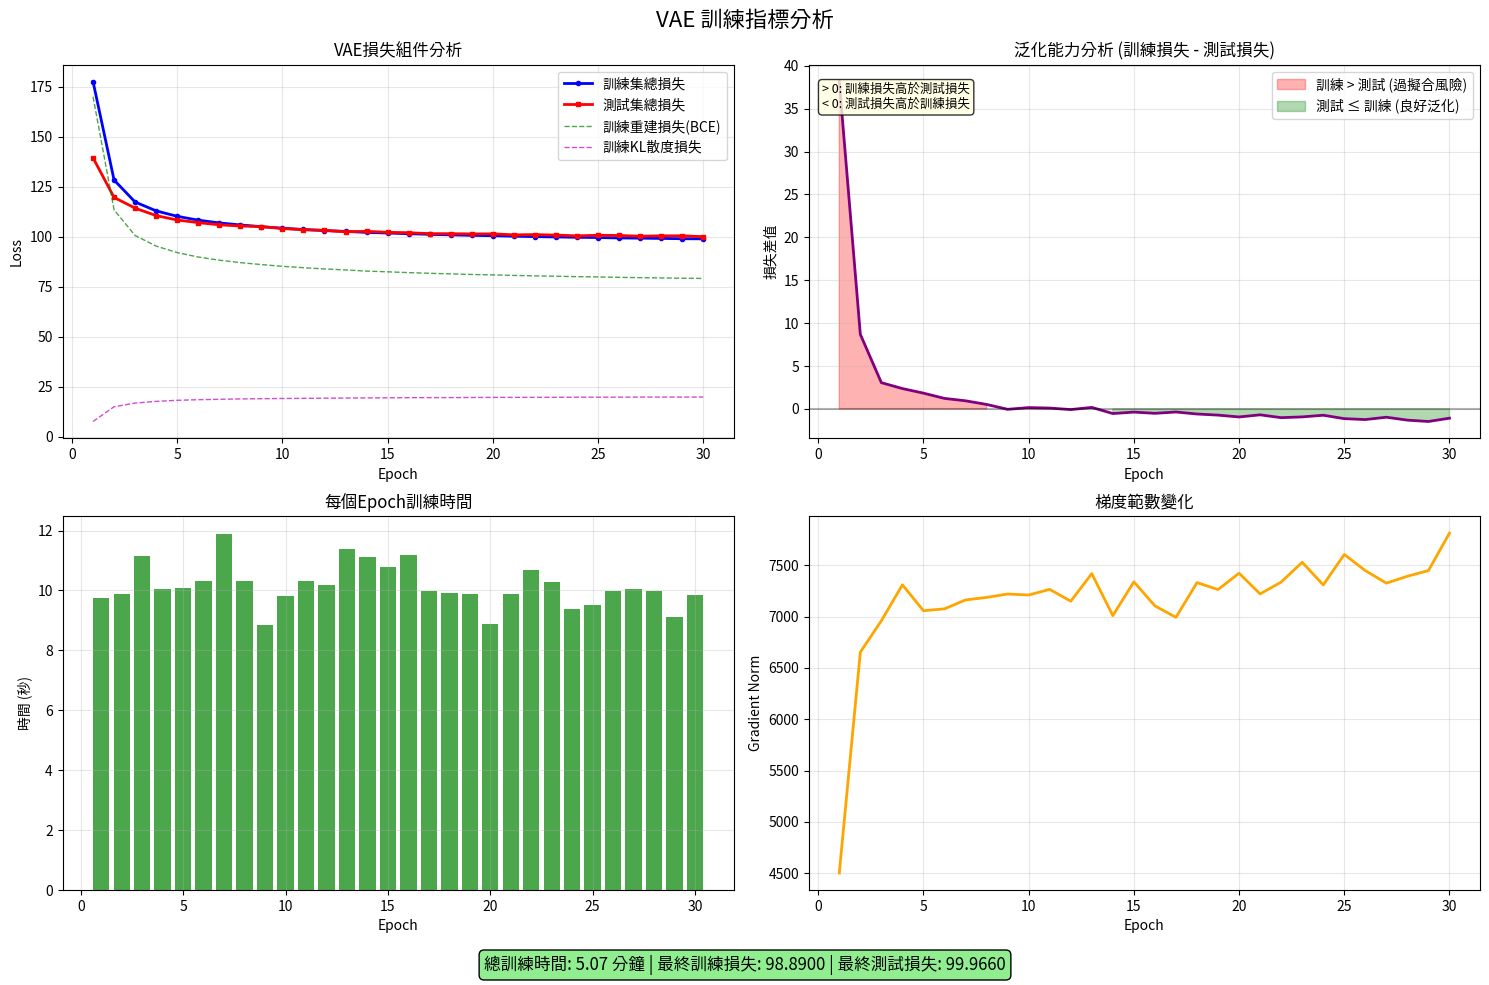

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"‰ΩøÁî®ËÆæÂ§á: {device}")

batch_size = 128  # ÊåâÁÖßË¶ÅÊ±Ç

# 1. ËºâÂÖ•MNISTË≥áÊñô
print("ËºâÂÖ•MNISTË≥áÊñô...")
train_dataloader,test_dataloader = get_mnist_dataloaders(batch_size=batch_size)

# 2. ÂâµÂª∫VAEÊ®°Âûã
print("ÂâµÂª∫VAEÊ®°Âûã...")
vae_model = VAE(input_dim=784, hidden_dim=400, latent_dim=20)
print(f"VAEÂèÉÊï∏Èáè: {sum(p.numel() for p in vae_model.parameters()):,}")

# 3. Ë®ìÁ∑¥VAEÊ®°Âûã
print("Ë®ìÁ∑¥VAE...")
trained_vae_model, vae_training_metrics = train_vae_model(
    vae_model,
    train_dataloader,
    test_dataloader,
    epochs=30,  # ÂèØË∞ÉÊï¥
    lr=1e-3,    # ÊåâÁÖßË¶ÅÊ±Ç
    device=device
)

# 4. Ë®ìÁ∑¥ÊåáÊ®ô
plot_vae_training_metrics(vae_training_metrics)

ÁîüÊàêVAEÂõæÂÉè...
Ê≠£Âú®ÁîüÊàê 10 ÂºµMNISTÂúñÂÉè...
VAEÁîüÊàêÂÆåÊàêÔºÅÊé®ÁêÜÊôÇÈñì: 0.0016 Áßí
Âπ≥ÂùáÊØèÂºµÂúñÁâá: 0.0002 Áßí


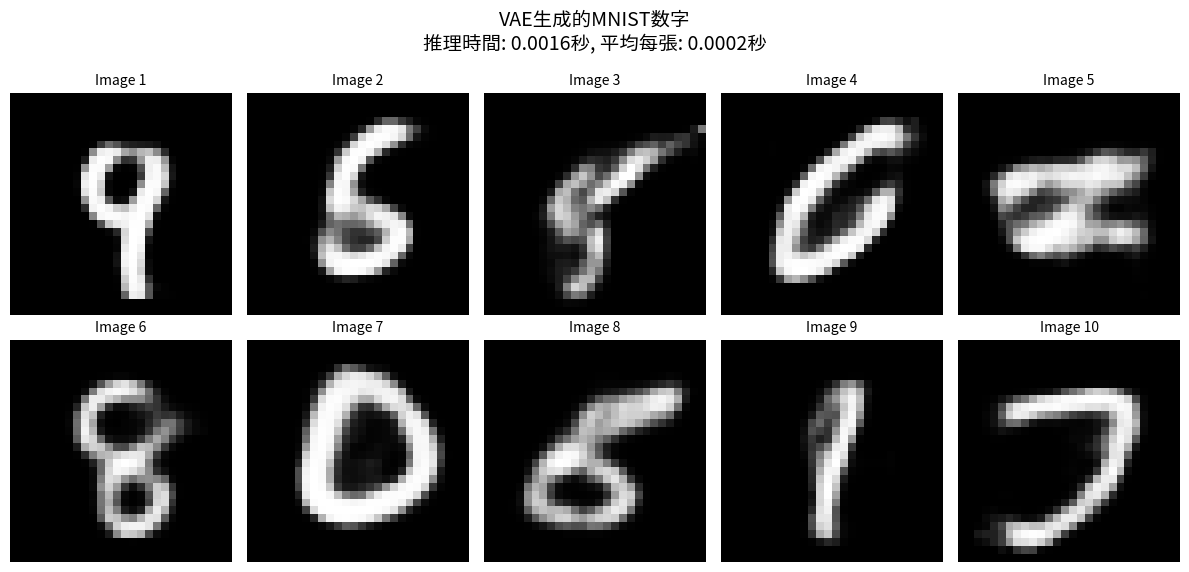

VAEÊ®°ÂûãÂ∑≤‰øùÂ≠ò‰∏∫ 'mnist_vae_model.pth'


In [ ]:
# 5. ÁîüÊàê10Âº†MNISTÂõæÂÉè
print("ÁîüÊàêVAEÂõæÂÉè...")
vae_generated_images, vae_inference_time = generate_vae_images(
    trained_vae_model, num_images=10, device=device
)

# 6. ÂèØËßÜÂåñÁªìÊûú
visualize_vae_images(vae_generated_images, "VAEÁîüÊàêÁöÑMNISTÊï∞Â≠ó", vae_inference_time)

# 7. ‰øùÂ≠òÊ®°ÂûãÂíåËÆ≠ÁªÉÊåáÊ†á
torch.save(trained_vae_model.state_dict(), 'mnist_vae_model.pth')
print("VAEÊ®°ÂûãÂ∑≤‰øùÂ≠ò‰∏∫ 'mnist_vae_model.pth'")

##Diffusion model

###Ê®°ÂûãË®≠ÂÆö

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import math
import matplotlib.pyplot as plt
from typing import Tuple, Optional
import warnings
import time

warnings.filterwarnings("ignore")
class DiffusionModel(nn.Module):
    def __init__(self, img_channels=1, img_size=28, timesteps=1000):
        super().__init__()
        self.img_channels = img_channels  # MNISTÁÇ∫1ÈÄöÈÅì(ÁÅ∞Èöé)
        self.img_size = img_size  # MNISTÁÇ∫28x28
        self.timesteps = timesteps

        # Âª∫Á´ãÂô™ËÅ≤Ë™øÂ∫¶
        self.beta_start = 0.0001
        self.beta_end = 0.02
        self.betas = self._cosine_beta_schedule()
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)

        # Ë®àÁÆóÂâçÂêëÈÅéÁ®ãÊâÄÈúÄÁöÑÂ∏∏Êï∏
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)

        # Ë®àÁÆóÂæåÂêëÈÅéÁ®ãÊâÄÈúÄÁöÑÂ∏∏Êï∏
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)

        # U-Net ÂéªÂô™Á∂≤Ë∑Ø (ÈÅ©ÈÖçMNIST)
        self.unet = UNet(img_channels, timesteps)

    def _cosine_beta_schedule(self):
        """È§òÂº¶Ë™øÂ∫¶Âô® - Êõ¥Á©©ÂÆöÁöÑÂô™ËÅ≤Ë™øÂ∫¶"""
        steps = self.timesteps + 1
        x = torch.linspace(0, self.timesteps, steps)
        alphas_cumprod = torch.cos(((x / self.timesteps) + 0.008) / 1.008 * math.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0, 0.999)

    def forward_diffusion_sample(self, x_0: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        ÂâçÂêëÈÅéÁ®ãÔºöÈÄêÊ≠•Â∞áÂô™ËÅ≤Âä†Âà∞ÂúñÁâá‰∏ä
        x_0: ÂéüÂßãMNISTÂúñÁâá (batch_size, 1, 28, 28)
        t: ÊôÇÈñìÊ≠•
        ËøîÂõû: (Âä†Âô™ÂæåÁöÑÂúñÁâá, Ê∑ªÂä†ÁöÑÂô™ËÅ≤)
        """
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self._get_index_from_list(self.sqrt_alphas_cumprod, t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self._get_index_from_list(self.sqrt_one_minus_alphas_cumprod, t, x_0.shape)

        # q(x_t | x_0) = N(sqrt(alpha_cumprod_t) * x_0, (1 - alpha_cumprod_t) * I)
        x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
        return x_t, noise

    def _get_index_from_list(self, vals, t, x_shape):
        """ÂæûÈ†êË®àÁÆóÁöÑÂÄº‰∏≠ÂèñÂá∫Â∞çÊáâÊôÇÈñìÊ≠•ÁöÑÂÄº"""
        batch_size = t.shape[0]
        out = vals.gather(-1, t.cpu())
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

    def forward(self, x_0: torch.Tensor) -> torch.Tensor:
        """
        Ë®ìÁ∑¥ÊôÇÁöÑÂâçÂêëÂÇ≥Êí≠
        """
        device = x_0.device
        batch_size = x_0.shape[0]

        # Èö®Ê©üÈÅ∏ÊìáÊôÇÈñìÊ≠•
        t = torch.randint(0, self.timesteps, (batch_size,), device=device).long()

        # ÂâçÂêëÊì¥Êï£
        x_t, noise = self.forward_diffusion_sample(x_0, t)

        # ‰ΩøÁî®U-NetÈ†êÊ∏¨Âô™ËÅ≤
        predicted_noise = self.unet(x_t, t)

        return predicted_noise, noise

    @torch.no_grad()
    def sample_timestep(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        ÈÄÜÂêëÈÅéÁ®ãÁöÑÂñÆÊ≠•Êé°Ê®£
        """
        betas_t = self._get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self._get_index_from_list(self.sqrt_one_minus_alphas_cumprod, t, x.shape)
        sqrt_recip_alphas_t = self._get_index_from_list(self.sqrt_recip_alphas, t, x.shape)

        # ‰ΩøÁî®U-NetÈ†êÊ∏¨Âô™ËÅ≤
        predicted_noise = self.unet(x, t)

        # Ë®àÁÆóÂùáÂÄº
        model_mean = sqrt_recip_alphas_t * (x - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t)

        if t[0] == 0:
            return model_mean
        else:
            posterior_variance_t = self._get_index_from_list(self.posterior_variance, t, x.shape)
            noise = torch.randn_like(x)
            return model_mean + torch.sqrt(posterior_variance_t) * noise

    @torch.no_grad()
    def sample(self, num_samples: int, device: str = 'cpu') -> torch.Tensor:
        """
        ÈÄÜÂêëÈÅéÁ®ãÔºöÂæûÂô™ËÅ≤ÁîüÊàêMNISTÊï∏Â≠óÂúñÁâá
        """
        # ÂæûÁ¥îÂô™ËÅ≤ÈñãÂßã (MNIST: 1ÈÄöÈÅì, 28x28)
        x = torch.randn((num_samples, self.img_channels, self.img_size, self.img_size), device=device)

        # ÈÄÜÂêëÊì¥Êï£
        for i in reversed(range(0, self.timesteps)):
            t = torch.full((num_samples,), i, device=device, dtype=torch.long)
            x = self.sample_timestep(x, t)

        return x


class UNet(nn.Module):
    """U-NetÂéªÂô™Á∂≤Ë∑Ø - ÈÅ©ÈÖçMNIST (28x28, ÂñÆÈÄöÈÅì)"""
    def __init__(self, img_channels=1, time_dim=1000):
        super().__init__()
        self.time_dim = time_dim

        # ÊôÇÈñìÂµåÂÖ•
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.ReLU()
        )

        # ‰∏ãÊé°Ê®£Ë∑ØÂæë (ÈÅ©ÈÖç28x28Ëº∏ÂÖ•)
        self.downs = nn.ModuleList([
            Block(img_channels, 32, time_dim),  # 28x28 -> 14x14
            Block(32, 64, time_dim),            # 14x14 -> 7x7
            Block(64, 128, time_dim),           # 7x7 -> 3x3 (Âêë‰∏ãÂèñÊï¥)
        ])

        # Áì∂È†∏Â±§
        self.bottleneck = Block(128, 256, time_dim)

        # ‰∏äÊé°Ê®£Ë∑ØÂæë
        self.ups = nn.ModuleList([
            Block(256 + 128, 128, time_dim),   # 3x3 -> 7x7
            Block(128 + 64, 64, time_dim),     # 7x7 -> 14x14
            Block(64 + 32, 32, time_dim),      # 14x14 -> 28x28
        ])

        # Ëº∏Âá∫Â±§
        self.output = nn.Conv2d(32, img_channels, 1)

    def forward(self, x, t):
        # ÊôÇÈñìÂµåÂÖ•
        t = self.time_mlp(t)

        # ‰∏ãÊé°Ê®£
        residuals = []
        for down in self.downs:
            x = down(x, t)
            residuals.append(x)
            x = F.max_pool2d(x, 2)

        # Áì∂È†∏
        x = self.bottleneck(x, t)

        # ‰∏äÊé°Ê®£
        for up in self.ups:
            x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
            residual_x = residuals.pop()
            # Á¢∫‰øùÁ∂≠Â∫¶ÂåπÈÖç
            if x.shape != residual_x.shape:
                x = F.interpolate(x, size=residual_x.shape[2:], mode='bilinear', align_corners=True)
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)

        return self.output(x)


class Block(nn.Module):
    """U-NetÁöÑÂü∫Êú¨Â°ä"""
    def __init__(self, in_ch, out_ch, time_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_dim, out_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.norm1 = nn.GroupNorm(min(8, out_ch), out_ch)  # ÈÅ©ÈÖçËºÉÂ∞èÁöÑÈÄöÈÅìÊï∏
        self.norm2 = nn.GroupNorm(min(8, out_ch), out_ch)

    def forward(self, x, t):
        h = self.conv1(x)
        h = self.norm1(h)
        h = F.relu(h)

        # Âä†ÂÖ•ÊôÇÈñìÂµåÂÖ•
        time_emb = self.time_mlp(t)
        time_emb = time_emb[(..., ) + (None, ) * 2]  # Êì¥Â±ïÁ∂≠Â∫¶‰ª•ÂåπÈÖçÁâπÂæµÂúñ
        h = h + time_emb

        h = self.conv2(h)
        h = self.norm2(h)
        h = F.relu(h)

        return h


class SinusoidalPositionEmbeddings(nn.Module):
    """Ê≠£Âº¶‰ΩçÁΩÆÂµåÂÖ•Áî®ÊñºÊôÇÈñìÊ≠•"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


###Ë≥áÊñôÈ†êËôïÁêÜÂíåÊî∂ÈõÜ

In [ ]:
def get_mnist_dataloaders(batch_size=128):
    """
    ËΩΩÂÖ•MNISTÊï∞ÊçÆÈõÜ - ÁÆÄÂåñÁâàÔºöËÆ≠ÁªÉÈõÜ + ÊµãËØïÈõÜ
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # ÂΩí‰∏ÄÂåñÂà∞[-1, 1]
    ])

    # ËÆ≠ÁªÉÈõÜ
    train_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        transform=transform,
        download=True
    )

    # ÊµãËØïÈõÜ
    test_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=False,
        transform=transform,
        download=True
    )

    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    test_dataloader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    print(f"Êï∞ÊçÆÈõÜ‰ø°ÊÅØ:")
    print(f"  ËÆ≠ÁªÉÈõÜ: {len(train_dataset)} Âº†ÂõæÁâá")
    print(f"  ÊµãËØïÈõÜ: {len(test_dataset)} Âº†ÂõæÁâá")

    return train_dataloader, test_dataloader




###Ë®ìÁ∑¥ÂíåÂèØË¶ñÂåñ

In [ ]:
def test_model_performance(model, test_dataloader, device='cuda'):
    """
    Âú®Ê∏¨Ë©¶ÈõÜ‰∏äË©ï‰º∞Ê®°ÂûãÊÄßËÉΩ
    """
    model.eval()
    total_test_loss = 0
    num_batches = len(test_dataloader)
    mse_loss = nn.MSELoss()

    print("Âú®Ê∏¨Ë©¶ÈõÜ‰∏äË©ï‰º∞Ê®°Âûã...")

    with torch.no_grad():
        for data, _ in test_dataloader:
            data = data.to(device)

            # ÂâçÂêëÂÇ≥Êí≠
            predicted_noise, true_noise = model(data)

            # Ë®àÁÆóÊêçÂ§±
            loss = mse_loss(predicted_noise, true_noise)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / num_batches
    print(f"Ê∏¨Ë©¶ÈõÜÂπ≥ÂùáÊêçÂ§±: {avg_test_loss:.4f}")
    return avg_test_loss


def train_diffusion_model(model, train_dataloader, test_dataloader, epochs=30, lr=1e-3, device='cuda'):
    """
    Ë®ìÁ∑¥ÂáΩÊï∏ - ÂåÖÂê´Ë®ìÁ∑¥ÈõÜÂíåÊ∏¨Ë©¶ÈõÜË©ï‰º∞
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()

    model.to(device)

    # Ë®ìÁ∑¥Áõ£ÊéßÊåáÊ®ô
    training_metrics = {
        'train_losses': [],      # Ë®ìÁ∑¥ÊêçÂ§±
        'test_losses': [],       # Ê∏¨Ë©¶ÊêçÂ§±
        'batch_losses': [],
        'gradient_norms': [],
        'epoch_times': [],
        'total_training_time': 0
    }

    print("ÈñãÂßãË®ìÁ∑¥MNIST Diffusion Model...")
    print(f"Ë®ìÁ∑¥ÈõÜÂ§ßÂ∞è: {len(train_dataloader.dataset)}")
    print(f"Ê∏¨Ë©¶ÈõÜÂ§ßÂ∞è: {len(test_dataloader.dataset)}")
    print(f"ÊâπÊ¨°Â§ßÂ∞è: {train_dataloader.batch_size}")
    print(f"Ë®ìÁ∑¥ÊâπÊ¨°Êï∏: {len(train_dataloader)}")
    print("=" * 60)

    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()

        # ============ Ë®ìÁ∑¥ÈöéÊÆµ ============
        model.train()
        total_train_loss = 0
        num_batches = len(train_dataloader)
        epoch_gradient_norms = []

        for batch_idx, (data, labels) in enumerate(train_dataloader):
            data = data.to(device)

            # ÂâçÂêëÂÇ≥Êí≠
            predicted_noise, true_noise = model(data)

            # MSEÂéªÂô™ÊêçÂ§±
            loss = mse_loss(predicted_noise, true_noise)

            # ÂèçÂêëÂÇ≥Êí≠
            optimizer.zero_grad()
            loss.backward()

            # Ë®àÁÆóÊ¢ØÂ∫¶ÁØÑÊï∏
            total_grad_norm = 0
            for param in model.parameters():
                if param.grad is not None:
                    param_grad_norm = param.grad.data.norm(2)
                    total_grad_norm += param_grad_norm.item() ** 2
            total_grad_norm = total_grad_norm ** (1. / 2)
            epoch_gradient_norms.append(total_grad_norm)

            optimizer.step()

            total_train_loss += loss.item()
            training_metrics['batch_losses'].append(loss.item())

            # ÊØè200ÂÄãÊâπÊ¨°‰∏îÊØè10ÂÄãepochÈ°ØÁ§∫ÈÄ≤Â∫¶
            if epoch % 10 == 0:
                if batch_idx % 200 == 0:
                    print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{num_batches}], '
                          f'Train Loss: {loss.item():.4f}, Grad Norm: {total_grad_norm:.4f}')

        # ============ Ê∏¨Ë©¶ÈöéÊÆµ ============
        model.eval()
        total_test_loss = 0
        test_batches = len(test_dataloader)

        with torch.no_grad():
            for data, _ in test_dataloader:
                data = data.to(device)
                predicted_noise, true_noise = model(data)
                loss = mse_loss(predicted_noise, true_noise)
                total_test_loss += loss.item()

        # Ë®òÈåÑepochÊåáÊ®ô
        epoch_time = time.time() - epoch_start_time
        avg_train_loss = total_train_loss / num_batches
        avg_test_loss = total_test_loss / test_batches
        avg_grad_norm = sum(epoch_gradient_norms) / len(epoch_gradient_norms)

        training_metrics['train_losses'].append(avg_train_loss)
        training_metrics['test_losses'].append(avg_test_loss)
        training_metrics['gradient_norms'].append(avg_grad_norm)
        training_metrics['epoch_times'].append(epoch_time)

        print(f'Epoch [{epoch+1}/{epochs}] - Ë®ìÁ∑¥ÊêçÂ§±: {avg_train_loss:.4f}, '
              f'Ê∏¨Ë©¶ÊêçÂ§±: {avg_test_loss:.4f}, Ê¢ØÂ∫¶ÁØÑÊï∏: {avg_grad_norm:.4f}, '
              f'Áî®ÊôÇ: {epoch_time:.1f}Áßí')
        print("-" * 60)

    # Á∏ΩË®ìÁ∑¥ÊôÇÈñì
    total_training_time = time.time() - total_start_time
    training_metrics['total_training_time'] = total_training_time

    print("=" * 60)
    print("Ë®ìÁ∑¥ÂÆåÊàêÔºÅ")
    print(f"Á∏ΩË®ìÁ∑¥ÊôÇÈñì: {total_training_time/60:.2f} ÂàÜÈêò")
    print(f"Âπ≥ÂùáÊØèepochÊôÇÈñì: {np.mean(training_metrics['epoch_times']):.1f} Áßí")
    print(f"ÊúÄÁµÇË®ìÁ∑¥ÊêçÂ§±: {training_metrics['train_losses'][-1]:.4f}")
    print(f"ÊúÄÁµÇÊ∏¨Ë©¶ÊêçÂ§±: {training_metrics['test_losses'][-1]:.4f}")
    print("=" * 60)

    return model, training_metrics


def plot_training_metrics(training_metrics):
    """
    Áπ™Ë£ΩË®ìÁ∑¥ÊåáÊ®ô - ÂåÖÂê´Ë®ìÁ∑¥ÊêçÂ§±ÂíåÊ∏¨Ë©¶ÊêçÂ§±Â∞çÊØî
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Diffusion Model Ë®ìÁ∑¥ÊåáÊ®ôÂàÜÊûê', fontsize=16)

    epochs = range(1, len(training_metrics['train_losses'])+1)

    # 1. Ë®ìÁ∑¥ÊêçÂ§± vs Ê∏¨Ë©¶ÊêçÂ§±
    axes[0, 0].plot(epochs, training_metrics['train_losses'], 'b-',
                    linewidth=2, label='Ë®ìÁ∑¥ÈõÜÊêçÂ§±', marker='o', markersize=3)
    axes[0, 0].plot(epochs, training_metrics['test_losses'], 'r-',
                    linewidth=2, label='Ê∏¨Ë©¶ÈõÜÊêçÂ§±', marker='s', markersize=3)
    axes[0, 0].set_title('Ë®ìÁ∑¥ÊêçÂ§± vs Ê∏¨Ë©¶ÊêçÂ§±')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('MSE Loss')
    axes[0, 0].legend(loc='upper right')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Ê≥õÂåñÂàÜÊûê (Ë®ìÁ∑¥ÊêçÂ§± - Ê∏¨Ë©¶ÊêçÂ§±)
    generalization_gap = [t - test for t, test in zip(training_metrics['train_losses'],
                                                     training_metrics['test_losses'])]
    axes[0, 1].plot(epochs, generalization_gap, 'purple', linewidth=2)
    axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[0, 1].fill_between(epochs, generalization_gap, 0, where=[g > 0 for g in generalization_gap],
                           alpha=0.3, color='red', label='Ë®ìÁ∑¥ > Ê∏¨Ë©¶ (ÈÅéÊì¨ÂêàÈ¢®Èö™)')
    axes[0, 1].fill_between(epochs, generalization_gap, 0, where=[g <= 0 for g in generalization_gap],
                           alpha=0.3, color='green', label='Ê∏¨Ë©¶ ‚â§ Ë®ìÁ∑¥ (ËâØÂ•ΩÊ≥õÂåñ)')
    axes[0, 1].set_title('Ê≥õÂåñËÉΩÂäõÂàÜÊûê (Ë®ìÁ∑¥ÊêçÂ§± - Ê∏¨Ë©¶ÊêçÂ§±)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('ÊêçÂ§±Â∑ÆÂÄº')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)

    # Ê∑ªÂä†Ëß£ÈáãÊñáÂ≠ó
    axes[0, 1].text(0.02, 0.95, '> 0: Ë®ìÁ∑¥ÊêçÂ§±È´òÊñºÊ∏¨Ë©¶ÊêçÂ§±\n< 0: Ê∏¨Ë©¶ÊêçÂ§±È´òÊñºË®ìÁ∑¥ÊêçÂ§±',
                   transform=axes[0, 1].transAxes, fontsize=9,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8),
                   verticalalignment='top')

    # 3. ÊØèÂÄãepochË®ìÁ∑¥ÊôÇÈñì
    axes[1, 0].bar(epochs, training_metrics['epoch_times'], alpha=0.7, color='green')
    axes[1, 0].set_title('ÊØèÂÄãEpochË®ìÁ∑¥ÊôÇÈñì')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('ÊôÇÈñì (Áßí)')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Ê¢ØÂ∫¶ÁØÑÊï∏ËÆäÂåñ
    axes[1, 1].plot(epochs, training_metrics['gradient_norms'], 'orange', linewidth=2)
    axes[1, 1].set_title('Ê¢ØÂ∫¶ÁØÑÊï∏ËÆäÂåñ')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Gradient Norm')
    axes[1, 1].grid(True, alpha=0.3)

    # Ê∑ªÂä†Á∏ΩÁµêË≥áË®ä
    final_train_loss = training_metrics['train_losses'][-1]
    final_test_loss = training_metrics['test_losses'][-1]
    total_time_text = (f"Á∏ΩË®ìÁ∑¥ÊôÇÈñì: {training_metrics['total_training_time']/60:.2f} ÂàÜÈêò | "
                      f"ÊúÄÁµÇË®ìÁ∑¥ÊêçÂ§±: {final_train_loss:.4f} | ÊúÄÁµÇÊ∏¨Ë©¶ÊêçÂ§±: {final_test_loss:.4f}")
    fig.text(0.5, 0.02, total_time_text, ha='center', fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()


def generate_mnist_images(model, num_images=10, device='cuda'):
    """
    Èö®Ê©üÁîüÊàêMNISTÊï∏Â≠óÂΩ±ÂÉè - Â¢ûÂä†Êé®ÁêÜÊôÇÈñìË®òÈåÑ
    """
    model.eval()

    # Êé®ÁêÜË®àÊôÇÈñãÂßã
    inference_start_time = time.time()

    with torch.no_grad():
        torch.manual_seed(42)

        print(f"Ê≠£Âú®ÁîüÊàê {num_images} ÂºµMNISTÂΩ±ÂÉè...")
        generated_images = model.sample(num_images, device=device)

        # Â∞áÂÄºÁØÑÂúçÂæû[-1, 1]ËΩâÊèõÂà∞[0, 1]
        generated_images = (generated_images + 1) / 2
        generated_images = torch.clamp(generated_images, 0, 1)

    # Êé®ÁêÜË®àÊôÇÁµêÊùü
    inference_time = time.time() - inference_start_time

    print(f"ÁîüÊàêÂÆåÊàêÔºÅÊé®ÁêÜÊôÇÈñì: {inference_time:.2f} Áßí")
    print(f"Âπ≥ÂùáÊØèÂºµÂúñÁâá: {inference_time/num_images:.2f} Áßí")

    return generated_images, inference_time


def visualize_mnist_images(images, title="Generated MNIST Images", inference_time=None):
    """
    Ë¶ñË¶∫ÂåñÁîüÊàêÁöÑMNISTÂúñÁâá - Â¢ûÂä†Êé®ÁêÜÊôÇÈñìÈ°ØÁ§∫
    """
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))

    # Ê®ôÈ°å‰∏≠Âä†ÂÖ•Êé®ÁêÜÊôÇÈñìË≥áË®ä
    if inference_time is not None:
        full_title = f"{title}\nÊé®ÁêÜÊôÇÈñì: {inference_time:.2f}Áßí, Âπ≥ÂùáÊØèÂºµ: {inference_time/len(images):.2f}Áßí"
    else:
        full_title = title

    fig.suptitle(full_title, fontsize=14)

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            img = images[i].squeeze().cpu().numpy()
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            ax.set_title(f'Image {i+1}', fontsize=10)
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

###‰∏ªÁ®ãÂºèÂíåÁµêÊûú

‰ΩøÁî®Ë£ùÁΩÆ: cuda
ËºâÂÖ•MNISTË≥áÊñôÈõÜ...
Êï∞ÊçÆÈõÜ‰ø°ÊÅØ:
  ËÆ≠ÁªÉÈõÜ: 60000 Âº†ÂõæÁâá
  ÊµãËØïÈõÜ: 10000 Âº†ÂõæÁâá
Âª∫Á´ãDiffusion Model...
Ê®°ÂûãÂèÉÊï∏Èáè: 3,654,825
ÈñãÂßãË®ìÁ∑¥...
ÈñãÂßãË®ìÁ∑¥MNIST Diffusion Model...
Ë®ìÁ∑¥ÈõÜÂ§ßÂ∞è: 60000
Ê∏¨Ë©¶ÈõÜÂ§ßÂ∞è: 10000
ÊâπÊ¨°Â§ßÂ∞è: 128
Ë®ìÁ∑¥ÊâπÊ¨°Êï∏: 469
Epoch [1/30], Batch [0/469], Train Loss: 1.1403, Grad Norm: 7.9997
Epoch [1/30], Batch [200/469], Train Loss: 0.0749, Grad Norm: 0.7740
Epoch [1/30], Batch [400/469], Train Loss: 0.0591, Grad Norm: 0.2802
Epoch [1/30] - Ë®ìÁ∑¥ÊêçÂ§±: 0.1038, Ê∏¨Ë©¶ÊêçÂ§±: 0.0632, Ê¢ØÂ∫¶ÁØÑÊï∏: 0.6351, Áî®ÊôÇ: 36.5Áßí
------------------------------------------------------------
Epoch [2/30] - Ë®ìÁ∑¥ÊêçÂ§±: 0.0591, Ê∏¨Ë©¶ÊêçÂ§±: 0.0560, Ê¢ØÂ∫¶ÁØÑÊï∏: 0.4289, Áî®ÊôÇ: 38.1Áßí
------------------------------------------------------------
Epoch [3/30] - Ë®ìÁ∑¥ÊêçÂ§±: 0.0530, Ê∏¨Ë©¶ÊêçÂ§±: 0.0507, Ê¢ØÂ∫¶ÁØÑÊï∏: 0.3316, Áî®ÊôÇ: 36.5Áßí
------------------------------------------------------------
Epoch [4/30] 

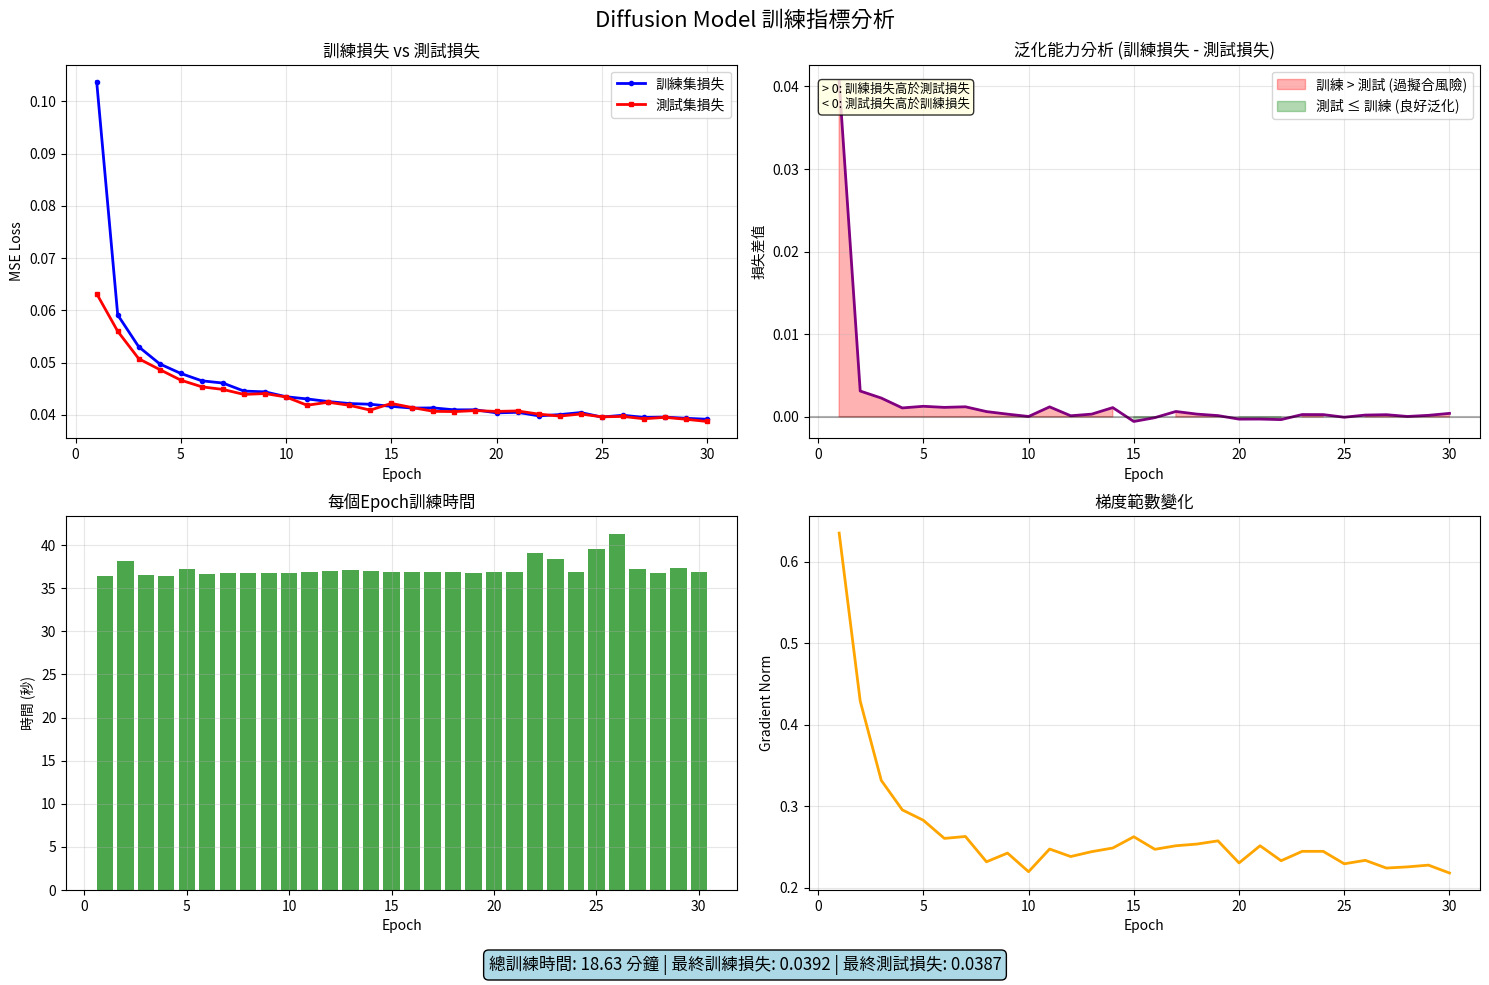

Ê®°ÂûãÂ∑≤ÂÑ≤Â≠òÁÇ∫ 'mnist_diffusion_model.pth'


In [ ]:
# ÂÆåÊï¥ÁöÑMNIST DiffusionÂØ¶È©ó
if __name__ == "__main__":
    # Ë®≠ÂÆöÂèÉÊï∏
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"‰ΩøÁî®Ë£ùÁΩÆ: {device}")

    batch_size = 128  # ÊåâÁÖßÂúñÁâáË¶ÅÊ±Ç

    # 1. ËºâÂÖ•MNISTË≥áÊñôÈõÜ
    print("ËºâÂÖ•MNISTË≥áÊñôÈõÜ...")
    train_dataloader, test_dataloader = get_mnist_dataloaders(batch_size=batch_size)

    # 2. Âª∫Á´ãÊ®°Âûã (MNIST: 1ÈÄöÈÅì, 28x28)
    print("Âª∫Á´ãDiffusion Model...")
    model = DiffusionModel(img_channels=1, img_size=28, timesteps=1000)
    print(f"Ê®°ÂûãÂèÉÊï∏Èáè: {sum(p.numel() for p in model.parameters()):,}")

    # 3. Ë®ìÁ∑¥Ê®°Âûã
    print("ÈñãÂßãË®ìÁ∑¥...")
    diffusion_model, training_metrics = train_diffusion_model(
        model, train_dataloader, test_dataloader, epochs=30, lr=1e-3, device=device
    )

    plot_training_metrics(training_metrics)



    #ÂÑ≤Â≠òÊ®°Âûã
    torch.save(diffusion_model.state_dict(), 'mnist_diffusion_model.pth')
    print("Ê®°ÂûãÂ∑≤ÂÑ≤Â≠òÁÇ∫ 'mnist_diffusion_model.pth'")


ÁîüÊàêÂΩ±ÂÉè...
Ê≠£Âú®ÁîüÊàê 10 ÂºµMNISTÂΩ±ÂÉè...
ÁîüÊàêÂÆåÊàêÔºÅÊé®ÁêÜÊôÇÈñì: 4.52 Áßí
Âπ≥ÂùáÊØèÂºµÂúñÁâá: 0.45 Áßí


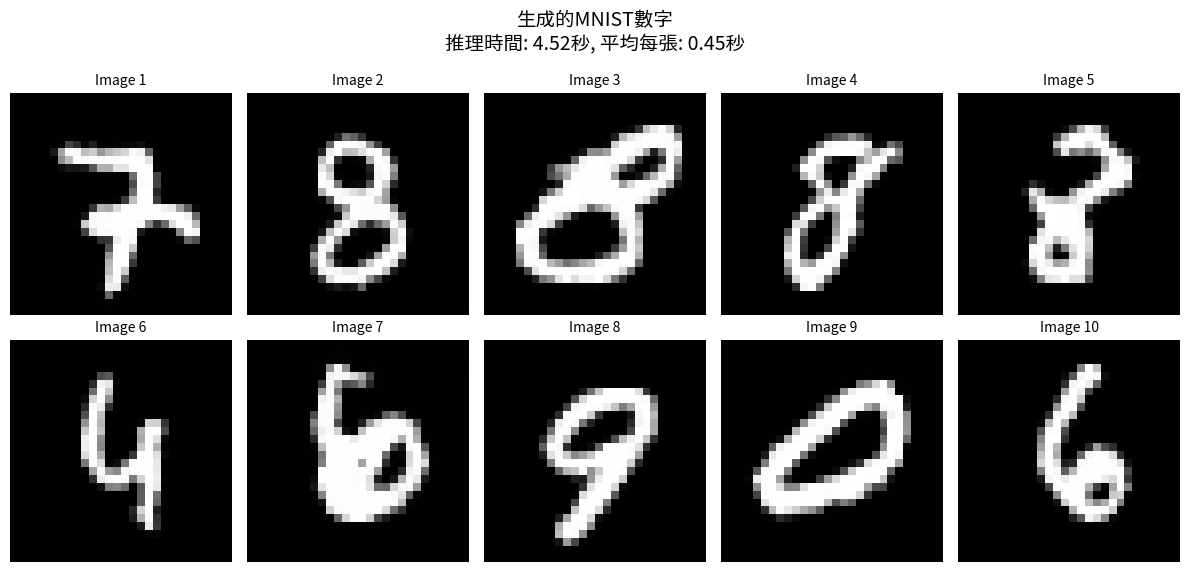

ÊàêÂäüÁîüÊàê 10 ÂºµMNISTÂΩ±ÂÉè
ÂΩ±ÂÉèÂ∞∫ÂØ∏: torch.Size([10, 1, 28, 28])


In [ ]:
print("ÁîüÊàêÂΩ±ÂÉè...")
# üé® ÁîüÊàêÂõæÂÉèÔºàÂ∏¶Êé®ÁêÜÊó∂Èó¥ÁõëÊéßÔºâ
diffusion_model_generated_images, inference_time = generate_mnist_images(
    diffusion_model, num_images=10, device=device
)

# üñºÔ∏è ÂèØËßÜÂåñÔºàÊòæÁ§∫Êé®ÁêÜÊó∂Èó¥Ôºâ
visualize_mnist_images(diffusion_model_generated_images, "ÁîüÊàêÁöÑMNISTÊï∏Â≠ó", inference_time)

print(f"ÊàêÂäüÁîüÊàê {diffusion_model_generated_images.shape[0]} ÂºµMNISTÂΩ±ÂÉè")
print(f"ÂΩ±ÂÉèÂ∞∫ÂØ∏: {diffusion_model_generated_images.shape}")

# ÂõõÁ®ÆÊ®°ÂûãÁîüÊàêÁµêÊûú

ÁîüÊàêVAEÂúñÁâá...
Ê≠£Âú®ÁîüÊàê 10 ÂºµMNISTÂúñÂÉè...
VAEÁîüÊàêÂÆåÊàêÔºÅÊé®ÁêÜÊôÇÈñì: 0.0010 Áßí
Âπ≥ÂùáÊØèÂºµÂúñÁâá: 0.0001 Áßí


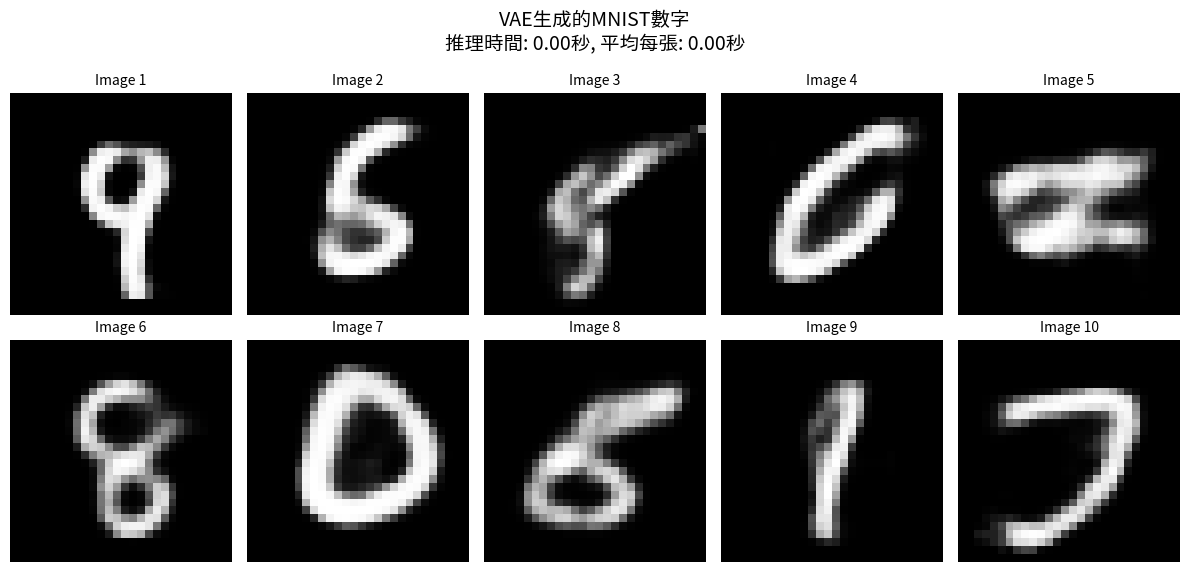

Diffusion modelÁîüÊàêÂΩ±ÂÉè...
Ê≠£Âú®ÁîüÊàê 10 ÂºµMNISTÂΩ±ÂÉè...
ÁîüÊàêÂÆåÊàêÔºÅÊé®ÁêÜÊôÇÈñì: 4.23 Áßí
Âπ≥ÂùáÊØèÂºµÂúñÁâá: 0.42 Áßí


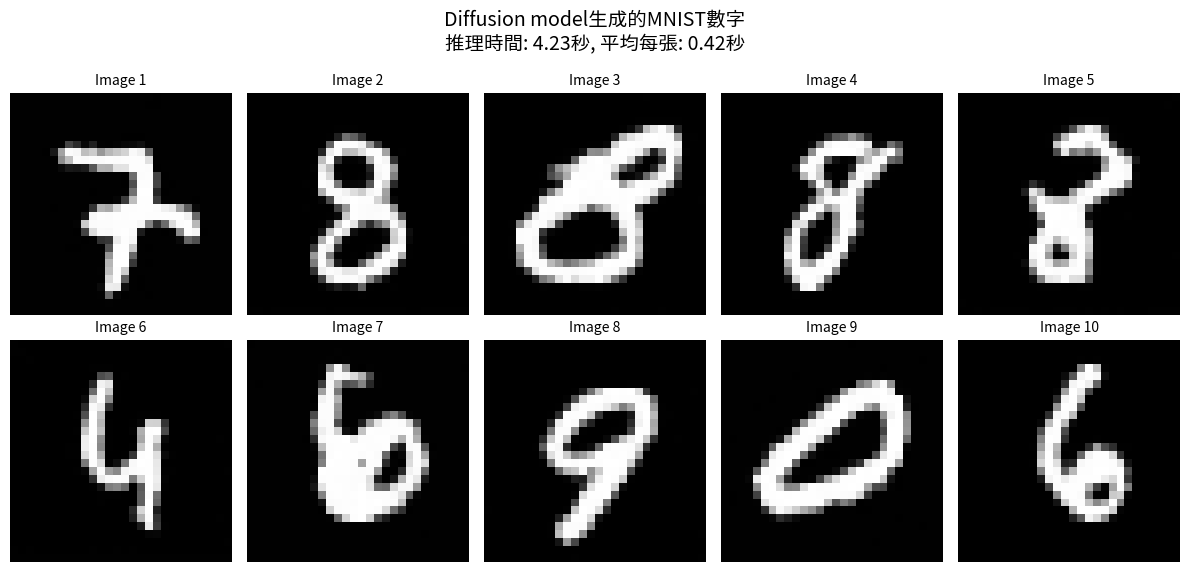

ÊàêÂäüÁîüÊàê 10 ÂºµMNISTÂΩ±ÂÉè
ÂΩ±ÂÉèÂ∞∫ÂØ∏: torch.Size([10, 1, 28, 28])


In [ ]:
#1.VAE
print("ÁîüÊàêVAEÂúñÁâá...")
vae_generated_images, vae_inference_time = generate_vae_images(
    trained_vae_model, num_images=10, device=device
)
visualize_mnist_images(vae_generated_images, "VAEÁîüÊàêÁöÑMNISTÊï∏Â≠ó", vae_inference_time)
#4.Diffusion model
print("Diffusion modelÁîüÊàêÂΩ±ÂÉè...")
# üé® ÁîüÊàêÂõæÂÉèÔºàÂ∏¶Êé®ÁêÜÊó∂Èó¥ÁõëÊéßÔºâ
diffusion_model_generated_images, inference_time = generate_mnist_images(
    diffusion_model, num_images=10, device=device
)

# üñºÔ∏è ÂèØËßÜÂåñÔºàÊòæÁ§∫Êé®ÁêÜÊó∂Èó¥Ôºâ
visualize_mnist_images(diffusion_model_generated_images, "Diffusion modelÁîüÊàêÁöÑMNISTÊï∏Â≠ó", inference_time)

print(f"ÊàêÂäüÁîüÊàê {diffusion_model_generated_images.shape[0]} ÂºµMNISTÂΩ±ÂÉè")
print(f"ÂΩ±ÂÉèÂ∞∫ÂØ∏: {diffusion_model_generated_images.shape}")

In [ ]:
#2.GAN
#3.CGAN

# Ê∏ÖÊô∞Â∫¶ÊØîËºÉ

# ÂèØÊéßÊÄßÔºàÊòØÂê¶ËÉΩÊåáÂÆöÊï∏Â≠óÔºâ

# Ë®ìÁ∑¥/Êé®ÁêÜÊïàÁéá


# Á©©ÂÆöÊÄßÔºàÊòØÂê¶Âá∫ÁèæÊ®°Á≥äÊàñ mode collapseÔºâ